Dispositivos GPU disponíveis:
[]

Informações detalhadas sobre dispositivos:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

TensorFlow está usando GPU? False

Nenhuma GPU disponível. O treinamento será realizado na CPU.
Amostra dos dados de treinamento:
   0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  782  \
0  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
3  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
4  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   783  label  
0    0      5  
1    0      0  
2    0      4  
3    0      1  
4    0      9  

[5 rows x 785 columns]


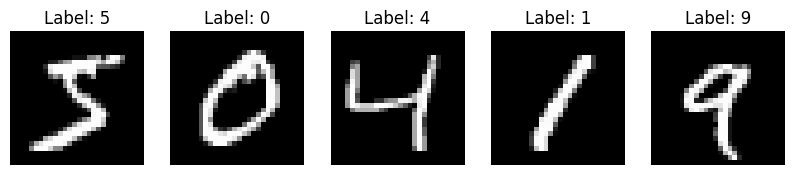

INFO :      Starting Flower server, config: num_rounds=1, no round_timeout
INFO:flwr:Starting Flower server, config: num_rounds=1, no round_timeout
INFO :      Flower ECE: gRPC server running (1 rounds), SSL is disabled
INFO:flwr:Flower ECE: gRPC server running (1 rounds), SSL is disabled
INFO :      [INIT]
INFO:flwr:[INIT]
INFO :      Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


Dados divididos entre clientes:
Cliente 1: 100 amostras
Cliente 2: 100 amostras
Cliente 3: 100 amostras
Iniciando treinamento federado...


In [ ]:

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import flwr as fl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Verificar se o TensorFlow está usando a GPU
print("Dispositivos GPU disponíveis:")
print(tf.config.list_physical_devices('GPU'))

# Se quiser mais detalhes sobre a configuração do TensorFlow
print("\nInformações detalhadas sobre dispositivos:")
print(tf.config.experimental.list_physical_devices())

# Verificar se o TensorFlow está configurado para usar GPU
print("\nTensorFlow está usando GPU?", tf.test.is_built_with_cuda())

# Se uma GPU estiver disponível, você pode forçar o TensorFlow a usá-la com:
if tf.config.list_physical_devices('GPU'):
    print("\nConfigurando TensorFlow para usar GPU...")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("\nNenhuma GPU disponível. O treinamento será realizado na CPU.")

# Bloco 2: Carregar o conjunto de dados MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Converter para DataFrame para visualização
df_train = pd.DataFrame(x_train.reshape(-1, 28*28))
df_train['label'] = y_train

# Exibir uma amostra dos dados
print("Amostra dos dados de treinamento:")
print(df_train.head())

# Plotar algumas imagens
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()

# Bloco 3: Normalizar e dividir os dados
x_train, x_test = x_train / 255.0, x_test / 255.0

# Dividir os dados para 3 clientes, garantindo 10 amostras por classe
num_clients = 3
client_data_size = 100
client_data = []

for i in range(num_clients):
    x_client = []
    y_client = []
    for digit in range(10):
        idx = np.where(y_train == digit)[0][i * 10:(i + 1) * 10]
        x_client.extend(x_train[idx])
        y_client.extend(y_train[idx])
    client_data.append((np.array(x_client), np.array(y_client)))

# Exibir a divisão dos dados
print("Dados divididos entre clientes:")
for i, (x_client, y_client) in enumerate(client_data):
    print(f"Cliente {i+1}: {x_client.shape[0]} amostras")

# Bloco 4: Definir o modelo e estratégia do cliente
def get_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(21, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class MnistClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train):
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.history = None

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        early_stopping = EarlyStopping(monitor='loss', patience=1, verbose=0)
        self.history = self.model.fit(self.x_train, self.y_train, epochs=1, batch_size=32, verbose=0, callbacks=[early_stopping])
        return self.model.get_weights(), len(self.x_train), {"loss": self.history.history['loss'][0], "accuracy": self.history.history['accuracy'][0]}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=0)
        return loss, len(x_test), {"accuracy": accuracy}

# Instanciar os clientes
clients = [MnistClient(get_model(), data[0], data[1]) for data in client_data]

# Bloco 5: Simular o treinamento federado
print("Iniciando treinamento federado...")
fl.server.start_server(
    server_address="localhost:4598",  
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        min_fit_clients=num_clients,
        min_available_clients=num_clients,  
    )
)

# Iniciar clientes (simulação local)
train_losses = []
train_accuracies = []
for idx, client in enumerate(clients):
    logger.debug("Treinamento iniciado para o cliente %d", idx + 1)
    fl.client.start_client(server_address="localhost:4598", client=client.to_client())
    
    if client.history:
        epoch = 1
        loss = client.history.history['loss'][0]
        logger.debug("Cliente %d, Época %d, Perda: %f", idx + 1, epoch, loss)
        train_losses.append(loss)
        train_accuracies.append(client.history.history['accuracy'][0])

# Bloco 6: Plotar os resultados reais do treinamento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Perda')
plt.title('Perda Real durante o Treinamento')
plt.xlabel('Cliente')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Precisão')
plt.title('Precisão Real durante o Treinamento')
plt.xlabel('Cliente')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()

# Bloco 7: Avaliar o modelo global
global_model = get_model()
global_weights = clients[0].get_parameters({})
global_model.set_weights(global_weights)

loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"Modelo Global - Perda: {loss}, Precisão: {accuracy}")

# Bloco 8: Avaliar cada modelo local
for i, client in enumerate(clients):
    local_model = get_model()
    local_weights = client.get_parameters({})
    local_model.set_weights(local_weights)
    
    loss, accuracy = local_model.evaluate(x_test, y_test, verbose=0)
    print(f"Cliente {i+1} - Perda: {loss}, Precisão: {accuracy}")